# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [64]:
# %pip install statsmodels

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../data/create_datasets.ipynb) in the [data](../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [68]:
DATA_STORE = '../data/assets.h5'

In [69]:
START = 2000
END = 2018

In [70]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [71]:
prices.info()
prices

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.400000,47.95,54.09,60.80,47.370000,26.71,39.050000,115.24,171.270000,32.46,...,4.28,4.53,NaN,NaN,NaN,3.94,15.66,NaN,84.10,23.95
2018-03-22,67.470000,44.92,52.31,60.18,45.940000,25.96,38.550000,111.71,168.845000,32.52,...,4.19,4.52,NaN,NaN,NaN,3.81,15.27,NaN,82.06,23.35
2018-03-23,66.060000,44.71,51.01,58.35,45.300000,25.36,37.200000,110.84,164.940000,31.78,...,4.05,4.40,NaN,NaN,NaN,3.80,15.12,NaN,80.60,23.55


In [72]:
stocks.info()
stocks

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,7.033000e+07,NaN,Finance
FLWS,8.333900e+08,1999.0,Consumer Services
FCCY,1.781400e+08,NaN,Finance
...,...,...,...
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [73]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [74]:
shared = prices.columns.intersection(stocks.index)

In [75]:
stocks = stocks.loc[shared, :]
stocks.info()
stocks

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


,marketcap,ipoyear,sector
ticker,,,
A,1.960000e+10,1999.0,Capital Goods
AA,8.540000e+09,2016.0,Basic Industries
AAL,1.767000e+10,NaN,Transportation
AAMC,1.104900e+08,NaN,Finance
AAN,3.200000e+09,NaN,Technology
...,...,...,...
ZIXI,2.944800e+08,NaN,Technology
ZNGA,3.550000e+09,2011.0,Technology
ZOES,1.974000e+08,2014.0,Consumer Services


In [76]:
prices = prices.loc[:, shared]
prices.info()
prices

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,4.466544,NaN,43.826745,NaN,37.06,NaN,NaN,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,4.466544,NaN,41.702530,NaN,36.50,NaN,NaN,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,4.408079,NaN,41.899948,NaN,37.13,NaN,NaN,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,4.350542,NaN,42.247403,NaN,35.25,NaN,NaN,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,4.640083,NaN,42.350060,NaN,38.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.400000,47.95,54.09,60.80,47.370000,26.71,39.050000,115.24,171.270000,32.46,...,48.89,22.120000,42.10,55.100000,4.28,4.53,3.94,15.66,84.10,23.95
2018-03-22,67.470000,44.92,52.31,60.18,45.940000,25.96,38.550000,111.71,168.845000,32.52,...,48.12,20.650000,41.05,53.070000,4.19,4.52,3.81,15.27,82.06,23.35
2018-03-23,66.060000,44.71,51.01,58.35,45.300000,25.36,37.200000,110.84,164.940000,31.78,...,46.70,20.000000,40.35,51.230000,4.05,4.40,3.80,15.12,80.60,23.55


In [77]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [78]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [79]:
monthly_prices.info()
monthly_prices

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: ME
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,45.157511,NaN,NaN,NaN,4.766882,NaN,1.211345,NaN,3.333330,NaN,...,NaN,4.176075,NaN,46.927728,NaN,30.88,NaN,NaN,NaN,NaN
2000-02-29,70.884807,NaN,NaN,NaN,4.941969,NaN,1.296459,NaN,3.682567,NaN,...,NaN,4.176075,NaN,42.110354,NaN,53.78,NaN,NaN,NaN,NaN
2000-03-31,70.953031,NaN,NaN,NaN,4.834658,NaN,1.334456,NaN,4.363369,NaN,...,NaN,3.712067,NaN,33.039089,NaN,72.81,NaN,NaN,NaN,NaN
2000-04-30,60.466992,NaN,NaN,NaN,4.360229,NaN,1.595875,NaN,3.985860,NaN,...,NaN,4.408079,NaN,32.935916,NaN,36.94,NaN,NaN,NaN,NaN
2000-05-31,50.233382,NaN,NaN,NaN,4.312221,NaN,1.852735,NaN,2.698793,NaN,...,NaN,4.118538,NaN,36.732135,NaN,28.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30,69.240000,41.51,50.49,72.0000,37.720000,43.66,36.450000,101.00,171.850000,39.36,...,33.61,19.920000,38.85,49.550000,4.570,4.40,4.100,15.98,72.29,21.800
2017-12-31,66.970000,53.87,52.03,81.6000,39.850000,37.82,36.700000,99.69,169.230000,38.24,...,33.84,21.490000,40.05,50.830000,4.140,4.38,4.000,16.72,72.04,20.825
2018-01-31,73.430000,52.02,54.32,69.0241,40.890000,32.39,36.400000,116.99,167.430000,35.26,...,38.52,23.310000,36.30,54.030000,3.945,4.23,3.585,14.72,76.73,20.750


In [80]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399525 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   399525 non-null  float64
 1   return_2m   399525 non-null  float64
 2   return_3m   399525 non-null  float64
 3   return_6m   399525 non-null  float64
 4   return_9m   399525 non-null  float64
 5   return_12m  399525 non-null  float64
dtypes: float64(6)
memory usage: 19.9+ MB


,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2001-01-31,-0.003653,0.022360,0.056104,0.049811,-0.052500,-0.015988
AAN,2001-01-31,0.116071,0.008439,-0.015687,-0.009856,-0.002912,-0.009572
AAON,2001-01-31,0.300170,0.034296,0.028670,-0.006238,0.010159,0.031027
AAPL,2001-01-31,0.430943,0.144685,0.033941,-0.132736,-0.110514,-0.070339
ABAX,2001-01-31,-0.073762,-0.042573,-0.044914,-0.003738,-0.028353,-0.031993
...,...,...,...,...,...,...,...
ZIXI,2018-03-31,0.083951,0.018737,0.000760,-0.017817,-0.028409,-0.007585
ZNGA,2018-03-31,0.069364,0.015912,-0.025652,-0.003559,0.001818,0.021989
ZOES,2018-03-31,0.000000,0.005420,-0.038117,0.027701,0.025046,-0.017982


## Drop stocks with less than 10 yrs of returns

In [81]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m  
ticker date                    
A      2001-01-31   -0.015988  
       2001-02-28   -0.084537  
       2001-03-31   -0.096606  
       2001-04-30   -0.066102  
       2001-05-31   -0.063425  
...                       ...  
ZUMZ   2017-11-30   -0.010687  
       2017-12-31   -0.003996  
       2018-01-31    0.002864  
       2018-02-28   -0.002905  
       2018-03-31    0.021422  

[360752 rows x 6 columns]

In [82]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


This code is visualizing the **Spearman correlation matrix** of the return features (`return_1m`, `return_2m`, `return_3m`, `return_6m`, `return_9m`, `return_12m`) using a **cluster map** from Seaborn.

### What does the code do?

-   `data.corr('spearman')`: Computes the Spearman rank correlation between all columns in [data](vscode-file://vscode-app/Applications/Visual%20Studio%20Code.app/Contents/Resources/app/out/vs/code/electron-sandbox/workbench/workbench.html). Spearman correlation measures monotonic relationships, not just linear ones.
-   `sns.clustermap(...)`: Plots a heatmap of the correlation matrix, clustering similar rows/columns together.
-   `annot=True`: Annotates each cell with the correlation value.
-   `center=0`: Centers the colormap at zero, so positive and negative correlations are visually distinct.
-   `cmap='Blues'`: Uses a blue color palette for the heatmap.

### How to interpret the clustermap?

-   **Cells**: Each cell shows the correlation between two return features (e.g., `return_1m` vs `return_3m`).
-   **Color intensity**: Darker blue means higher positive correlation; lighter means lower or negative correlation.
-   **Annotations**: The number in each cell is the actual Spearman correlation coefficient.
-   **Clustering**: Rows and columns are reordered so that features with similar correlation patterns are grouped together, making it easier to spot groups of highly correlated features.

**In summary:**\
The clustermap helps you quickly see which return features are most strongly related (positively or negatively) and how they cluster together, which is useful for feature selection and understanding redundancy in your data.


If the **Spearman correlation** between `return_6m` and `return_9m` is **0.77**, while the correlation between `return_6m` and `return_1m` is **0.36**, it means:

-   **`return_6m` and `return_9m`** move much more closely together (their ranks are more similar across the dataset).
-   **`return_6m` and `return_1m`** are less closely related (their ranks are less similar).

**In this context:**\
Returns over similar time horizons (6 and 9 months) are more strongly related than returns over very different horizons (6 months vs 1 month). This is expected: longer-term returns share more overlapping data and trends, while short-term returns can be more volatile and less related to longer-term trends.

**Practical implication:**

-   Features like `return_6m` and `return_9m` may be somewhat redundant (highly correlated).
-   Features like `return_6m` and `return_1m` capture more independent information.

This helps you decide which features to keep or combine when building models, to avoid redundancy and multicollinearity.

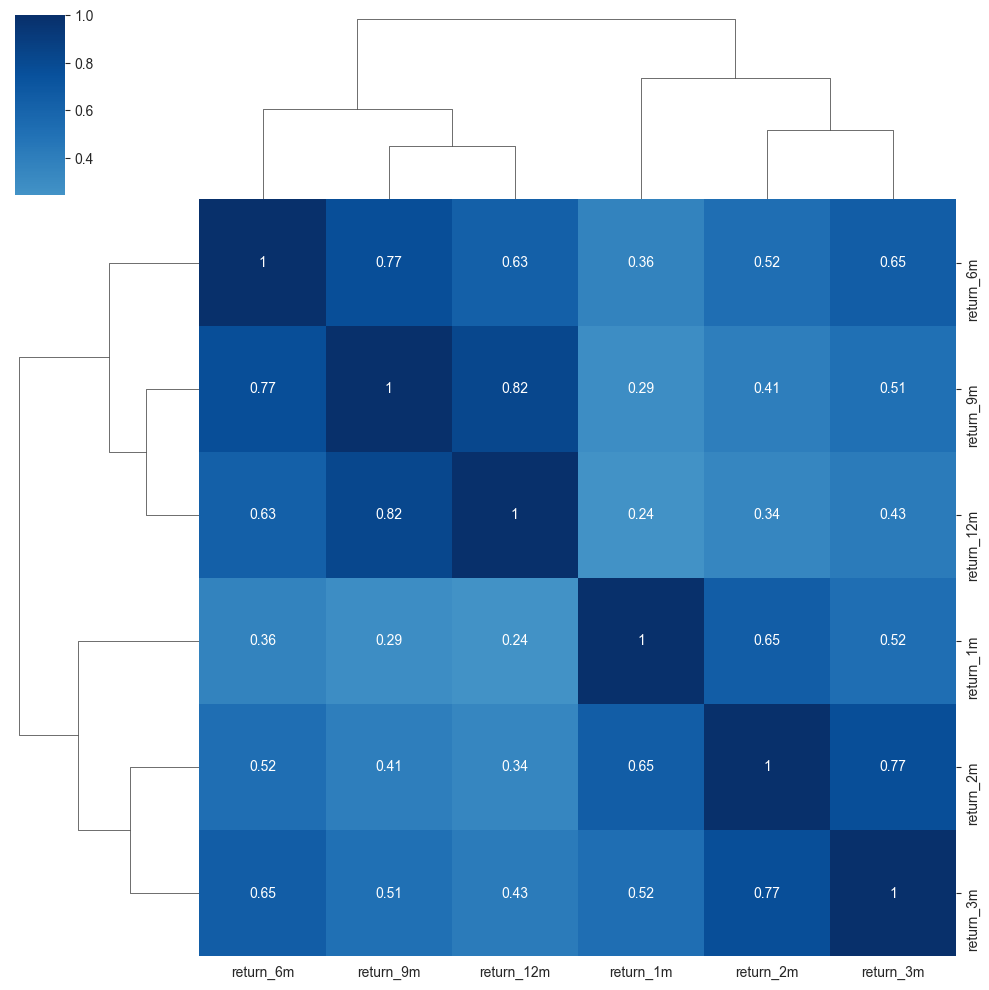

In [83]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [84]:
data.index.get_level_values('ticker').nunique()

1838

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [85]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()
factor_data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 2000-01-31 to 2025-03-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  303 non-null    float64
 1   SMB     303 non-null    float64
 2   HML     303 non-null    float64
 3   RMW     303 non-null    float64
 4   CMA     303 non-null    float64
dtypes: float64(5)
memory usage: 14.2 KB


,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0421,-0.0112,-0.0615,0.0456
2000-02-29,0.0245,0.1846,-0.0977,-0.1895,-0.0113
2000-03-31,0.0521,-0.1554,0.0850,0.1165,-0.0120
2000-04-30,-0.0635,-0.0475,0.0645,0.0807,0.0563
2000-05-31,-0.0439,-0.0386,0.0459,0.0405,0.0147
...,...,...,...,...,...
2024-11-30,0.0648,0.0459,0.0016,-0.0229,-0.0205
2024-12-31,-0.0315,-0.0383,-0.0299,0.0190,-0.0121
2025-01-31,0.0280,-0.0122,0.0163,-0.0234,-0.0324


In [86]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()
factor_data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0325  0.0523 -0.0505 -0.0520 -0.0521  -0.003653
       2001-02-28 -0.1003  0.0287  0.1223  0.0912  0.0901  -0.329564
       2001-03-31 -0.0725  0.0233  0.0647  0.0334  0.0372  -0.146389
       2001-04-30  0.0794 -0.0088 -0.0464 -0.0318 -0.0319   0.269444
       2001-05-31  0.0068  0.0355  0.0338  0.0029  0.0195  -0.140220
...                   ...     ...     ...     ...     ...        ...
ZUMZ   2017-11-30  0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.235127
       2017-12-31  0.0106 -0.0105  0.0005  0.0073  0.0179  -0.044725
       2018-01-31  0.0558 -0.0321 -0.0132 -0.0075 -0.0105  -0.003601
       2018-02-28 -0.0364  0.0034 -0.0110  0.0053 -0.0236  -0.050602
       2018-03-31 -0.0235  0.0361 -0.0021 -0.0041  0.0008   0.197970

[360752 rows x 6 columns]

In [87]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
A      2001-01-31       NaN       NaN       NaN       NaN       NaN
       2001-02-28       NaN       NaN       NaN       NaN       NaN
       2001-03-31       NaN       NaN       NaN       NaN       NaN
       2001-04-30       NaN       NaN       NaN       NaN       NaN
       2001-05-31       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
ZUMZ   2017-11-30 -0.772464  1.307170  1.383565  3.440287  0.969714
       2017-12-31 -0.967332  1.658391  1.602919  3.652837  0.260709
       2018-01-31  0.077844  1.176237  1.394623  2.987292  0.517126
       2018-02-28  0.347310  1.030070  1.425830  2.697481  0.542308
       2018-03-31  0.248885  1.655982  1.225991  2.926128  0.468988

[360752 rows x 5 columns]

In [88]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.983032,0.632169,0.120847,-0.060290,0.024915,1.501384
std,0.915238,1.264011,1.613412,1.934661,2.191881,3.359027
min,-10.199863,-10.633288,-16.183797,-22.618157,-19.328166,-32.550880
25%,0.469122,-0.118535,-0.716097,-0.988859,-1.079466,0.000000
50%,0.934244,0.545304,0.093240,0.036463,0.043981,1.221654
75%,1.447608,1.315012,0.949558,0.964712,1.158975,3.181547
max,10.999413,10.764474,15.114795,16.774616,18.243728,33.647498


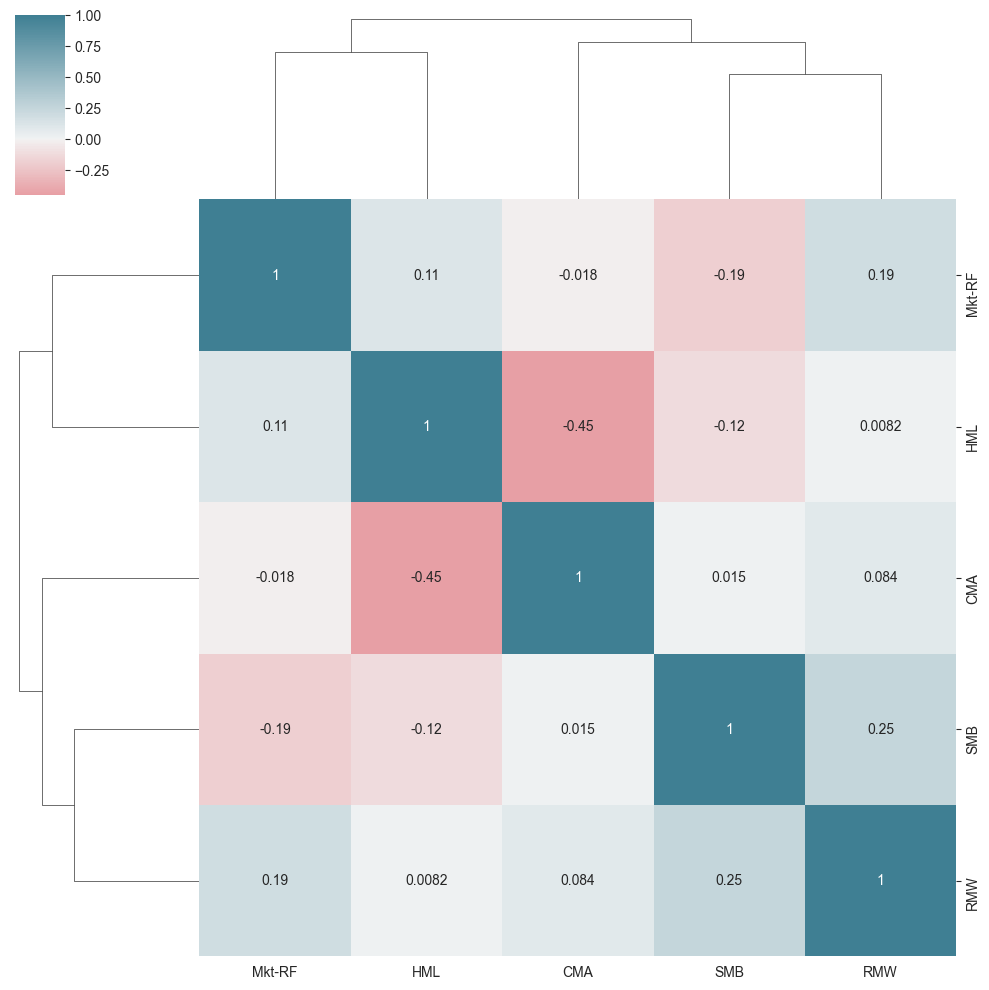

In [89]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [90]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988       NaN       NaN       NaN       NaN   
       2001-02-28   -0.084537       NaN       NaN       NaN       NaN   
       2001-03-31   -0.096606       NaN       NaN       NaN       NaN   
       2001-04-30   -0.066102       NaN       NaN       NaN       NaN   
       2001-05-31   -0.063425       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292   
       2018-03-31    0.021422  0.347310  1.030070  1.425830  2.697481   

                        CMA  
ticker date                  
A      2001-01-31       NaN  
       2001-02-28       NaN  
       2001-03-31       NaN  
       2001-04-30       NaN  
       2001-05-31       NaN  
...                     ...  
ZUMZ   2017-11-30  1.298115  
       2017-12-31  0.969714  
       2018-01-31  0.260709  
       2018-02-28  0.517126  
       2018-03-31  0.542308  

[360752 rows x 11 columns]

### Impute mean for missing factor betas

In [91]:
# data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data[factors] = data.groupby('ticker')[factors].transform(lambda x: x.fillna(x.mean()))
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.270597  0.554078 -0.673132 -1.309609   
       2001-02-28   -0.084537  1.270597  0.554078 -0.673132 -1.309609   
       2001-03-31   -0.096606  1.270597  0.554078 -0.673132 -1.309609   
       2001-04-30   -0.066102  1.270597  0.554078 -0.673132 -1.309609   
       2001-05-31   -0.063425  1.270597  0.554078 -0.673132 -1.309609   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292   
       2018-03-31    0.021422  0.347310  1.030070  1.425830  2.697481   

                        CMA  
ticker date                  
A      2001-01-31  0.652856  
       2001-02-28  0.652856  
       2001-03-31  0.652856  
       2001-04-30  0.652856  
       2001-05-31  0.652856  
...                     ...  
ZUMZ   2017-11-30  1.298115  
       2017-12-31  0.969714  
       2018-01-31  0.260709  
       2018-02-28  0.517126  
       2018-03-31  0.542308  

[360752 rows x 11 columns]

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [92]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.270597  0.554078 -0.673132 -1.309609   
       2001-02-28   -0.084537  1.270597  0.554078 -0.673132 -1.309609   
       2001-03-31   -0.096606  1.270597  0.554078 -0.673132 -1.309609   
       2001-04-30   -0.066102  1.270597  0.554078 -0.673132 -1.309609   
       2001-05-31   -0.063425  1.270597  0.554078 -0.673132 -1.309609   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292   
       2018-03-31    0.021422  0.347310  1.030070  1.425830  2.697481   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.652856    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.652856    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.652856   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.652856   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.652856    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.298115   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  0.969714    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.260709   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.517126    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.542308   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  
ticker date                                    
A      2001-01-31    -0.012335      -0.072092  
       2001-02-28     0.245026       0.031898  
       2001-03-31     0.049783       0.078511  
       2001-04-30    -0.335545       0.039645  
       2001-05-31     0.076795      -0.040108  
...                        ...            ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  
       2017-12-31     0.040729      -0.051853  
       2018-01-31     0.006465      -0.052554  
       2018-02-28     0.047697       0.030295  
       2018-03-31    -0.176548      -0.021157  

[360752 rows x 17 columns]

## Date Indicators

In [93]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.270597  0.554078 -0.673132 -1.309609   
       2001-02-28   -0.084537  1.270597  0.554078 -0.673132 -1.309609   
       2001-03-31   -0.096606  1.270597  0.554078 -0.673132 -1.309609   
       2001-04-30   -0.066102  1.270597  0.554078 -0.673132 -1.309609   
       2001-05-31   -0.063425  1.270597  0.554078 -0.673132 -1.309609   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292   
       2018-03-31    0.021422  0.347310  1.030070  1.425830  2.697481   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.652856    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.652856    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.652856   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.652856   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.652856    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.298115   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  0.969714    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.260709   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.517126    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.542308   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  year  month  
ticker date                                                 
A      2001-01-31    -0.012335      -0.072092  2001      1  
       2001-02-28     0.245026       0.031898  2001      2  
       2001-03-31     0.049783       0.078511  2001      3  
       2001-04-30    -0.335545       0.039645  2001      4  
       2001-05-31     0.076795      -0.040108  2001      5  
...                        ...            ...   ...    ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  2017     11  
       2017-12-31     0.040729      -0.051853  2017     12  
       2018-01-31     0.006465      -0.052554  2018      1  
       2018-02-28     0.047697       0.030295  2018      2  
       2018-03-31    -0.176548      -0.021157  2018      3  

[360752 rows x 19 columns]

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [94]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non-null  float64
 16  

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-02-28   -0.084537  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-03-31   -0.096606  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-04-30   -0.066102  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-05-31   -0.063425  1.270597  0.554078 -0.673132 -1.309609  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318  ...   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287  ...   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837  ...   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292  ...   
       2018-03-31    0.021422  0.347310  1.030070  1.425830  2.697481  ...   

                   momentum_12  momentum_3_12  year  month  return_1m_t-1  \
ticker date                                                                 
A      2001-01-31    -0.012335      -0.072092  2001      1            NaN   
       2001-02-28     0.245026       0.031898  2001      2      -0.003653   
       2001-03-31     0.049783       0.078511  2001      3      -0.329564   
       2001-04-30    -0.335545       0.039645  2001      4      -0.146389   
       2001-05-31     0.076795      -0.040108  2001      5       0.269444   
...                        ...            ...   ...    ...            ...   
ZUMZ   2017-11-30    -0.245814      -0.215989  2017     11      -0.024862   
       2017-12-31     0.040729      -0.051853  2017     12       0.235127   
       2018-01-31     0.006465      -0.052554  2018      1      -0.044725   
       2018-02-28     0.047697       0.030295  2018      2      -0.003601   
       2018-03-31    -0.176548      -0.021157  2018      3      -0.050602   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [95]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [96]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [97]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non-null  float64
 16  

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-02-28   -0.084537  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-03-31   -0.096606  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-04-30   -0.066102  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-05-31   -0.063425  1.270597  0.554078 -0.673132 -1.309609  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318  ...   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287  ...   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837  ...   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292  ...   
       2018-03-31    0.021422  0.347310  1.030070  1.425830  2.697481  ...   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.044725       0.235127      -0.024862   

                   return_1m_t-6  target_1m  target_2m  target_3m  target_6m  \
ticker date                                                                    
A      2001-01-31            NaN  -0.329564  -0.249443  -0.105747  -0.101978   
       2001-02-28            NaN  -0.146389   0.040966  -0.023317  -0.049781   
       2001-03-31            NaN   0.269444   0.044721   0.018842  -0.072607   
       2001-04-30            NaN  -0.140220  -0.087246  -0.098192  -0.089198   
       2001-05-31            NaN  -0.031008  -0.076414  -0.075527  -0.033904   
...                          ...        ...        ...        ...        ...   
ZUMZ   2017-11-30      -0.206128  -0.044725  -0.024380  -0.033200        NaN   
       2017-12-31      -0.133333  -0.003601  -0.027386   0.042579        NaN   
       2018-01-31       0.028340  -0.050602   0.066466        NaN        NaN   
       2018-02-28      -0.019685   0.197970        NaN        NaN        NaN   
 

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [98]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [99]:
stocks.info()
stocks

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


,marketcap,ipoyear,sector
ticker,,,
A,1.960000e+10,1999.0,Capital Goods
AA,8.540000e+09,2016.0,Basic Industries
AAL,1.767000e+10,NaN,Transportation
AAMC,1.104900e+08,NaN,Finance
AAN,3.200000e+09,NaN,Technology
...,...,...,...
ZIXI,2.944800e+08,NaN,Technology
ZNGA,3.550000e+09,2011.0,Technology
ZOES,1.974000e+08,2014.0,Consumer Services


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [100]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1838 entries, A to ZUMZ
dtypes: float64(1838)
memory usage: 2.9 MB


In [101]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [102]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [103]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non-null  float64
 16  

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [105]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features            frame        (shape->[358914,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/sp500/fred                     frame        (shape->[2609,1])     
/sp500/stocks                   frame        (shape->[503,7])      
/sp500/stooq                    frame        (shape->[17700,5])    
/us_equities/stocks             frame        (shape->[6834,6])     


## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [106]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64
 13  momentum_6     